In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision
import os 
from os.path import join as opj
from datasets import load_dataset
import tqdm

import pytorch_lightning as pl
from torch import nn
from torchsummary import summary
from pytorch_lightning import Trainer
from versatile_diffusion_dual_guided_fake_images import *
from transformers import AutoProcessor, AutoModelForCausalLM
from sklearn.linear_model import Ridge, RidgeCV
import torch.nn.functional as F
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
from torchvision import transforms
from scipy.signal import stft
from sklearn.linear_model import RidgeClassifier
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report
from monai.networks import nets
import wandb
import pandas as pd
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
import copy
import seaborn as sns
# from pl_bolts.models.autoencoders.components import (
#     resnet18_decoder,
#     resnet18_encoder,
# )


/home/matteo/anaconda3/envs/deep/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_dir="/home/matteo/data/EEG/ImageNetEEG"
imagenet_dir="/home/matteo/data/ImageNet/ILSVRC/Data/CLS-LOC/"

file=opj(dataset_dir,"eeg_14_70_std.pth")
data=torch.load(file)

block=torch.load(opj(dataset_dir,"block_splits_by_image_all.pth"))

In [3]:
eeg_train=[]
eeg_val=[]
eeg_test=[]

subject_train=[]
subject_val=[]
subject_test=[]


img_train=[]
img_val=[]
img_test=[]

label_train=[]
label_val=[]
label_test=[]

start=40
stop=480

for i in range(11965):
    eeg=data["dataset"][i]["eeg"][:,start:stop]
    img_idx=data["dataset"][i]["image"]
    img_name=data["images"][img_idx]
    label=data["dataset"][i]["label"]
    subject=data["dataset"][i]["subject"]
    
    if i in block["splits"][0]["train"]:
        eeg_train.append(eeg)
        img_train.append(img_name)
        label_train.append(label)
        subject_train.append(subject)
        
    elif i in block["splits"][0]["val"]:
        eeg_val.append(eeg)
        img_val.append(img_name)
        label_val.append(label)
        subject_val.append(subject)
        
    elif i in block["splits"][0]["test"]:
        eeg_test.append(eeg)
        img_test.append(img_name)
        label_test.append(label)
        subject_test.append(subject)
        
    
eeg_train=torch.stack(eeg_train,0)
eeg_val=torch.stack(eeg_val,0)
eeg_test=torch.stack(eeg_test,0)

img_train = [opj(imagenet_dir,"train",i.split("_")[0],f"{i}.JPEG") for i in img_train]
img_val = [opj(imagenet_dir,"train",i.split("_")[0],f"{i}.JPEG") for i in img_val]
img_test = [opj(imagenet_dir,"train",i.split("_")[0],f"{i}.JPEG") for i in img_test]


In [4]:
spectro_train=[]
spectro_val=[]
spectro_test=[]

for eeg in tqdm.tqdm(eeg_train,0):
    f, t, Zxx = stft(eeg, 1000, nperseg=40)
    spectro_train.append(torch.tensor(np.abs(Zxx)))
                         
for eeg in tqdm.tqdm(eeg_val,0):
    f, t, Zxx = stft(eeg, 1000, nperseg=40)
    spectro_val.append(torch.tensor(np.abs(Zxx)))
    
for eeg in tqdm.tqdm(eeg_test,0):
    f, t, Zxx = stft(eeg, 1000, nperseg=40)
    spectro_test.append(torch.tensor(np.abs(Zxx)))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1997/1997 [02:16<00:00, 14.61it/s]


In [5]:
batch=64
device="cuda:0"

pipe_embed = VersatileDiffusionDualGuidedFromCLIPEmbeddingPipeline.from_pretrained("shi-labs/versatile-diffusion", )

pipe_embed.remove_unused_weights()
pipe_embed = pipe_embed.to(device)

Fetching 17 files: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 78527.72it/s]


In [6]:
train_clip_img_embeds=[]


with torch.no_grad():
    for i in tqdm.tqdm(range(0,len(eeg_train),batch)):

        #save img data
        y= img_train[i:i+batch]
                         
        images=[Image.open(i).convert("RGB") for i in y]

        #encode images in CLIP
        image_features=pipe_embed._encode_image_prompt(images,device=device,num_images_per_prompt=1,do_classifier_free_guidance=False).cpu()
        train_clip_img_embeds.append(image_features)

    
        
    train_clip_img_embeds = torch.cat(train_clip_img_embeds,axis=0)


val_clip_img_embeds=[]
with torch.no_grad():
    for i in tqdm.tqdm(range(0,len(eeg_val),batch)):

        #save img data
        y= img_val[i:i+batch]
                         
        images=[Image.open(i).convert("RGB") for i in y]

        #encode images in CLIP
        image_features=pipe_embed._encode_image_prompt(images,device=device,num_images_per_prompt=1,do_classifier_free_guidance=False).cpu()
        val_clip_img_embeds.append(image_features)

    
        
    val_clip_img_embeds = torch.cat(val_clip_img_embeds,axis=0)

test_clip_img_embeds=[]
with torch.no_grad():
    for i in tqdm.tqdm(range(0,len(eeg_test),batch)):

        #save img data
        y= img_test[i:i+batch]
                         
        images=[Image.open(i).convert("RGB") for i in y]

        #encode images in CLIP
        image_features=pipe_embed._encode_image_prompt(images,device=device,num_images_per_prompt=1,do_classifier_free_guidance=False).cpu()
        test_clip_img_embeds.append(image_features)

    
        
    test_clip_img_embeds = torch.cat(test_clip_img_embeds,axis=0)
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [02:02<00:00,  3.84s/it]


In [7]:
class Encoder(nn.Module):
    def __init__(self, num_input_channels: int, base_channel_size: int, latent_dim: int, act_fn: object = nn.GELU):
        """
        Args:
           num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
           base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
           latent_dim : Dimensionality of latent representation z
           act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=1, stride=1),  # 32x32 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=2),  # 16x16 => 8x8
            act_fn(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=2),  # 8x8 => 4x4
            act_fn(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=2),  # 8x8 => 4x4
            act_fn(),
            nn.Flatten(),  # Image grid to single feature vector
            nn.LazyLinear(latent_dim),
        )

    def forward(self, x):
        return self.net(x)

In [8]:
import torch
import torch.nn as nn
import pytorch_lightning as pl

class ContrastiveModel(pl.LightningModule):

    def contrastive_loss(self, z_i, z_j):

        z_i = nn.functional.normalize(z_i, dim=1)
        z_j = nn.functional.normalize(z_j, dim=1)
        
        logits = (z_i @ z_j.T) / self.temperature
        similarities = z_j @ z_j.T
        # targets = torch.nn.functional.softmax(similarities * self.temperature, dim=-1)

        targets = torch.arange(logits.shape[0]).long().to(logits.device)
        
        loss = torch.nn.functional.cross_entropy(logits, targets)
        return loss
    
    def mean_contrastive(self, z_i, z_j, temperature=1.0):
        return nn.functional.mse_loss(z_i, z_j)+self.contrastive_loss(z_i, z_j, temperature=temperature)/8
    
    def cosine_loss(self, z_i, z_j, temperature=1.0):
        cosine_similarity = torch.nn.functional.cosine_similarity(z_i, z_j).mean()
        return 1- cosine_similarity

    def __init__(self,  num_input_channels: int, base_channel_size: int, latent_dim: int, act_fn: object = nn.GELU, temperature=.1,loss_type="contrastive"):
        super().__init__()
        
        self.temperature=temperature
        
        self.model = Encoder(num_input_channels, base_channel_size, latent_dim, act_fn)

        self.loss_type=loss_type
        if loss_type=="contrastive":
            self.loss_fn=self.contrastive_loss
        elif loss_type=="mean_contrastive":
            self.loss_fn=self.mean_contrastive
        
        elif loss_type=="mse":
            self.loss_fn=torch.nn.functional.mse_loss
        elif loss_type=="cosine":
            self.loss_fn=self.cosine_loss
        
        self.train_losses = []
        self.train_mse=[]
        self.train_cosine=[]
        self.val_losses = []
        self.val_mse=[]
        self.val_cosine=[]
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y= batch
        # x = x.float()
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        self.train_losses.append(loss.item())

        mse_loss = torch.nn.functional.mse_loss(y_hat, y)
        cosine_similarity = torch.nn.functional.cosine_similarity(y_hat, y).mean()
        self.train_mse.append(mse_loss.item())
        self.train_cosine.append(cosine_similarity.item())

        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        # x = x.float()

        y_hat = self(x)

        loss=self.loss_fn(y_hat, y)
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        
        mse_loss = torch.nn.functional.mse_loss(y_hat, y)
        self.log('val_mse_loss', mse_loss, on_epoch=True, prog_bar=True)
        
        cosine_similarity = torch.nn.functional.cosine_similarity(y_hat, y).mean()
        self.log('val_cosine_similarity', cosine_similarity, on_epoch=True, prog_bar=True)
        
        self.val_losses.append(loss.item())
        self.val_mse.append(mse_loss.item())
        self.val_cosine.append(cosine_similarity.item())
        return mse_loss
        
    def configure_optimizers(self):
        # return torch.optim.AdamW(self.parameters(), lr=3e-4, weight_decay=0)
        # add a scheduler
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-4, weight_decay=1e-3)
        # use a scheduler that every 100 steps, it will reduce the learning rate by 0.1
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=50, verbose=True)
        # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}



In [ ]:
train_dataset = TensorDataset(torch.stack(spectro_train),train_clip_img_embeds[:,0])
val_dataset = TensorDataset(torch.stack(spectro_val),val_clip_img_embeds[:,0])
test_dataset = TensorDataset(torch.stack(spectro_test),test_clip_img_embeds[:,0])

In [ ]:
x,y=train_dataset[0]    

x.shape, y.shape

BS=256

clip_train_dataloader=DataLoader(train_dataset, batch_size=BS, shuffle=True)
clip_val_dataloader=DataLoader(val_dataset, batch_size=BS, shuffle=False)
clip_test_dataloader=DataLoader(test_dataset, batch_size=BS, shuffle=False)

In [ ]:
brain_model = ContrastiveModel(num_input_channels= 128, base_channel_size=192, latent_dim=768,act_fn=nn.ReLU, loss_type="contrastive")

summary(brain_model, x.shape,device="cpu")

# Instantiate a PyTorch Lightning Trainer
trainer = pl.Trainer(max_epochs=80, devices=[0])

# Train the model
trainer.fit(brain_model, clip_train_dataloader, clip_test_dataloader)

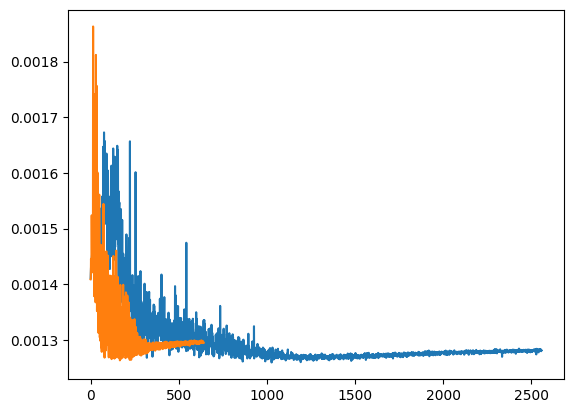

In [21]:
plt.plot(brain_model.train_mse, label='train')
plt.plot(brain_model.val_mse, label='val')

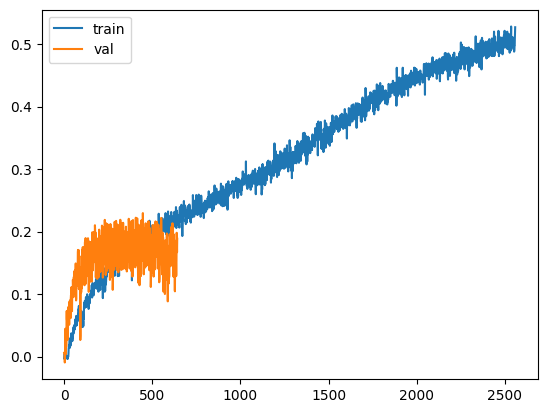

In [22]:
plt.plot(brain_model.train_cosine, label='train')
plt.plot(brain_model.val_cosine, label='val')
plt.legend()

In [23]:
x,y=next(iter(clip_test_dataloader))

y_pred=[]
with torch.no_grad():

    for x,y in tqdm.tqdm(clip_test_dataloader):
        y_hat=brain_model(x).cpu()
        y_pred.append(y_hat)

y_pred=torch.cat(y_pred,0)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:32<00:00,  4.08s/it]


In [24]:
# similarity=  torch.nn.functional.softmax(.1*torch.nn.functional.normalize(test_clip_img_embeds[:,0],-1) @ torch.nn.functional.normalize(y_pred,.1).T)

z_i=y_pred
z_j=test_clip_img_embeds[:,0]

z_i = nn.functional.normalize(z_i, dim=1)
z_j = nn.functional.normalize(z_j, dim=1)

logits = (z_i @ z_j.T) / .1

similarity =  torch.nn.functional.softmax(logits,-1)

# similarity=  torch.nn.functional.softmax(10*torch.nn.functional.normalize(test_clip_img_embeds[:,0],-1) @ torch.nn.functional.normalize(y_pred.T,-1))

In [60]:
top_indices=torch.topk(similarity,30,1).indices

In [61]:
top_indices

tensor([[1536, 1869,  205,  ..., 1670,    6, 1337],
        [ 685,   20, 1018,  ...,  435, 1766,  102],
        [1403, 1736,   72,  ..., 1168,  835,  170],
        ...,
        [1592, 1925,  261,  ..., 1056,  391,  723],
        [1464, 1797, 1131,  ...,  721, 1720, 1387],
        [1663,  664,  332,  ..., 1891, 1225,  892]])

In [67]:
## voglio selezionare immagini diverse!

selected_images=[]
for top_idxs in top_indices:
    selected_images.append(list(set(np.array(img_test)[top_idxs])))

1997

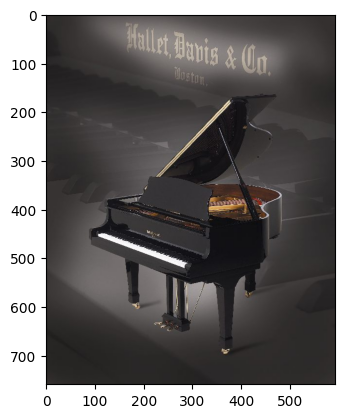

In [73]:
plt.imshow(Image.open(selected_images[0][4]))

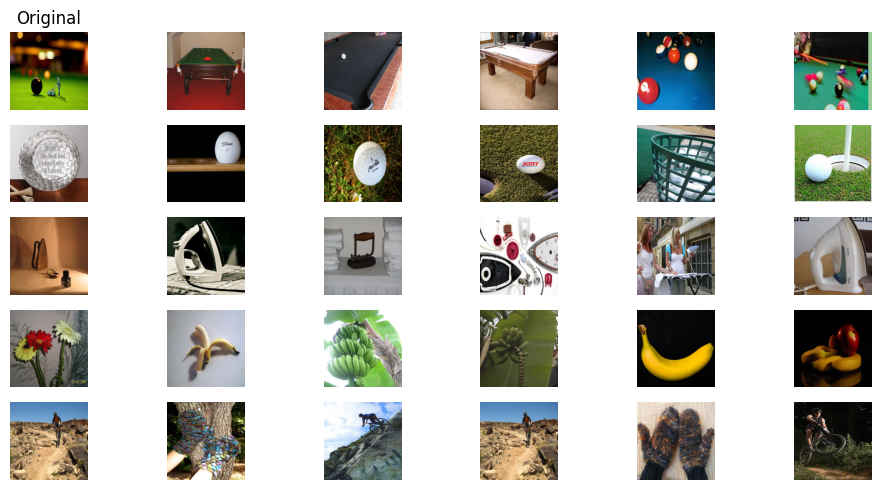

In [92]:
idx=90
fig, ax = plt.subplots(5,6,figsize=(10,5))  


for i in range(5):
    ax[i,0].imshow(Image.open(img_test[idx+i]).convert("RGB").resize((224,224)))
    ax[i,1].imshow(Image.open(selected_images[idx+i][0]).convert("RGB").resize((224,224)))

    ax[i,2].imshow(Image.open(selected_images[idx+i][1]).convert("RGB").resize((224,224)))
    ax[i,3].imshow(Image.open(selected_images[idx+i][2]).convert("RGB").resize((224,224)))
    ax[i,4].imshow(Image.open(selected_images[idx+i][3]).convert("RGB").resize((224,224)))

    ax[i,5].imshow(Image.open(selected_images[idx+i][4]).convert("RGB").resize((224,224)))

    ax[i,0].axis("off")
    ax[i,1].axis("off")
    ax[i,2].axis("off")
    ax[i,3].axis("off")
    ax[i,4].axis("off")
    ax[i,5].axis("off")

ax[0,0].set_title("Original")   


plt.tight_layout()


In [1]:
print()

## Save model

In [100]:
os.makedirs(f"models_contrastive",exist_ok=True)

torch.save(brain_model, "models_contrastive/whole_pl_model.pt")
torch.save(brain_model.state_dict(), "models_contrastive/whole_pl_model_state_dict.pt")

torch.save(brain_model.model, "models_contrastive/encoder.pt")
torch.save(brain_model.model.state_dict(), "models_contrastive/encoder_state_dict.pt")


## Compute some metrics